In [6]:
import pybamm as pb;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
import scipy.optimize
import random;import time, signal
from matplotlib import gridspec
fs=10;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

In [10]:
# load model
model = pb.lithium_ion.DFN()

# create geometry
geometry = model.default_geometry

# load parameter values and process model and geometry
param = pb.ParameterValues("ORegan2022")


In [11]:
#GITT Experiment text
V_max = 4.2;        V_min = 2.5
exp_topup_text = [ (
    f"Discharge at 0.5C until {V_max-0.2}V", # start from discharge as it is easier for unbalanced cells
    f"Charge at 0.3C until {V_max}V",
    f"Hold at {V_max}V until C/100",
    "Rest for 1 hours", 
    ) ] 
exp_GITT_text = [ (
    "Rest for 60 seconds (1 second period)", 
    "Discharge at 1C for 144 seconds or until 2.5V (0.1 second period)", 
    "Rest for 1 hour (1 second period)"
    ) ]

experiment = pb.Experiment( 
    exp_topup_text * 1 + exp_GITT_text * 25 ) 

var_pts = {
    "x_n": 5,  # negative electrode
    "x_s": 5,  # separator 
    "x_p": 5,  # positive electrode
    "r_n": 80,  # negative particle
    "r_p": 20,  # positive particle
}

In [14]:
# run pybamm model
sim = pb.Simulation(
    model=model, 
    experiment = experiment,
    parameter_values=param,
    solver=model.default_solver,
    var_pts=var_pts, )
solution = sim.solve(calc_esoh=False,)

In [15]:
OCP_PE = solution["Positive electrode open-circuit potential [V]"]
OCP_NE = solution["Negative electrode open-circuit potential [V]"]
OCP = solution["Voltage [V]"]
OCP_NE_GRAD = solution["Gradient of negative electrode potential [V.m-1]"]
OCP_PE_GRAD = solution["Gradient of positive electrode potential [V.m-1]"]
#OCP_GRAD = solution["Voltage gradient [V.m-1]"]

In [16]:
quick_plot = pb.QuickPlot(
    solution, ["Positive electrode open-circuit potential [V]", "Negative electrode open-circuit potential [V]", "Voltage [V]"]
)
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=0.0, description='t', max=28.13987480657081, step=0.2813987480657081),…

In [17]:
t = solution["Time [s]"].entries
x = solution["x [m]"].entries[:, 0]
print(OCP_NE_GRAD(t=t)[0])

[-1.32067940e-01 -1.32067269e-01 -1.32066917e-01 ... -3.88516130e-08
 -3.87625472e-08 -3.86734814e-08]


Figure saved to /Users/felixwatson/Desktop/UROP/Code/Project_files/Model_testing/Figures/DMA_Overall_Plots_GITT.png


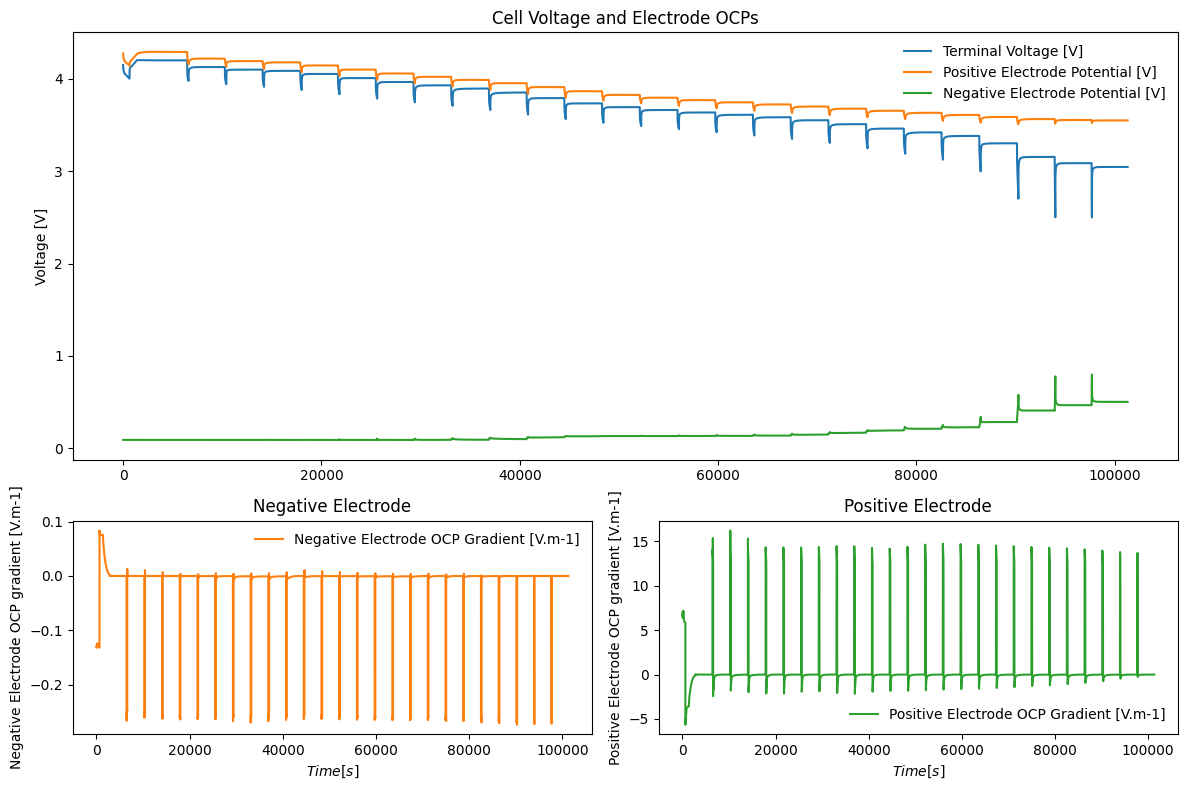

In [22]:
def Plot_Comp_DMA_Overall_GITT(sol, Save_Fig=False, fig_name=None):
    OCP_PE = sol["Positive electrode open-circuit potential [V]"]
    OCP_NE = sol["Negative electrode open-circuit potential [V]"]
    OCP = sol["Terminal voltage [V]"]    
    OCP_NE_GRAD = sol["Gradient of negative electrode potential [V.m-1]"]
    OCP_PE_GRAD = sol["Gradient of positive electrode potential [V.m-1]"]
    t = sol["Time [s]"].entries
    x = sol["x [m]"].entries[:, 0]
    
    # Create a gridspec for custom subplot layout: 1 row on top, 2 beloW
    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1])

    # Top subplot spans both columns
    ax1 = fig.add_subplot(gs[0, :])
    # Bottom left and right subplots
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])

    # First subplot: Voltage and OCPs
    ax1.plot(t, OCP(t))
    ax1.set_ylabel("Voltage [V]")

    ax1.plot(t, OCP_PE(t=t)[0])
    ax1.plot(t, OCP_NE(t=t)[0])

    ax1.legend(
        [
            "Terminal Voltage [V]",
            "Positive Electrode Potential [V]",
            "Negative Electrode Potential [V]"
        ], loc='best', frameon=False
    )
    ax1.set_title("Cell Voltage and Electrode OCPs")

    # Second subplot: Negative Electrode OCP Gradient
    ax3.plot(t, OCP_NE_GRAD(t=t)[0], label="Negative Electrode OCP Gradient [V.m-1]", color='C1')
    ax3.set_ylabel("Negative Electrode OCP gradient [V.m-1]")
    ax3.set_xlabel(r"$Time [s]$")
    ax3.legend(loc='best', frameon=False)
    ax3.set_title("Negative Electrode")

    # Third subplot: Positive Electrode OCP Gradient
    ax4.plot(t, OCP_PE_GRAD(t=t)[0], label="Positive Electrode OCP Gradient [V.m-1]", color='C2')
    ax4.set_ylabel("Positive Electrode OCP gradient [V.m-1]")
    ax4.set_xlabel(r"$Time [s]$")
    ax4.legend(loc='best', frameon=False)
    ax4.set_title("Positive Electrode")

    plt.tight_layout()

    if Save_Fig:
        Save_path = os.path.join(
            "/Users/felixwatson/Desktop/UROP/Code/Project_files/Model_testing/Figures", fig_name
        )
        plt.savefig(Save_path, dpi=600)
        print(f"Figure saved to {Save_path}")\
        
    plt.show()

Plot_Comp_DMA_Overall_GITT(sol=solution, Save_Fig=True, fig_name="DMA_Overall_Plots_GITT.png")

In [ ]:
model.variables.search("gradient")

Results for 'gradient': ['Gradient of negative electrode potential [V.m-1]', 'Gradient of positive electrode potential [V.m-1]', 'Gradient of electrolyte potential [V.m-1]', 'Gradient of negative electrolyte potential [V.m-1]', 'Gradient of separator electrolyte potential [V.m-1]', 'Gradient of positive electrolyte potential [V.m-1]']
